## Instructions

In this assignment, you will learn about regularization methods, gradient descent, and stochastic gradient descent. Again, be careful not to use the same data for training (any stage of training) and testing your model. Your tasks are:
1. "Communities and Crime" dataset. Use the "Communities and Crime" dataset from the previous assignment with the same preprocessing.
    The last column of the dataset (ViolentCrimesPerPop) is your target variable. Remove the attributes state, county, community, community name, and fold (columns 1 to 5). https://archive.ics.uci.edu/dataset/183/communities+and+crime
    1. Fit the models using Ridge and Lasso regression from Scikit-learn,
    2. Try different values of the regularization parameter and evaluate its effect (use Scikit-learn). You can also use functions that help you search the parameter space.
    3. Choose the optimal regularization parameter and describe the process.
    4. Compare the attributes you selected with forward attribute selection (the results from the previous assignment) with the attributes selected by the lasso method.
    5. Comment on the results.
2. "Wine quality" dataset. Download the "Wine quality" dataset. Choose only the white wine data. Preprocess the data as you did in the previous assignments. The data is available at https://archive.ics.uci.edu/dataset/186/wine+quality. You will be doing a regression. Wine quality grades (last column) are your target.
    1. Implement batch gradient descent and stochastic gradient descent to find the solution for ridge regression from scratch.
    2. Test it on "Wine quality" data.
    3. Test different learning rates and try to find a good one. Comment on the results.
    4. Compare the times to convergence and the results of the two gradient descents that you implemented.


In [459]:
# Imports
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

---
### Helper functions

In [460]:
def train_test_split(
    X: pd.DataFrame,
    y: pd.Series,
    test_size: float = 0.2,
    shuffle: bool = True,
    seed: int | None = None,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Splits the dataset into training and testing sets.

    Parameters
    ----------
    X : pd.DataFrame
        Features dataframe.
    y : pd.Series
        Target variable series.
    test_size : float, optional
        Proportion of the dataset to include in the test split (default is 0.2).
    shuffle : bool, optional
        Whether to shuffle the data before splitting (default is True).
    seed : int, optional
        Random seed for reproducibility (default is None).

    Returns
    ----------
    X_train : pd.DataFrame
        Training features dataframe.
    X_test : pd.DataFrame
        Testing features dataframe.
    y_train : pd.Series
        Training target variable series.
    y_test : pd.Series
        Testing target variable series.
    """
    indices = np.arange(len(X))

    # Shuffle
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(indices)

    n_test = int(len(X) * test_size)

    test_indices = indices[:n_test]
    train_indices = indices[n_test:]

    X_train = X.iloc[train_indices].reset_index(drop=True)
    X_test = X.iloc[test_indices].reset_index(drop=True)
    y_train = y.iloc[train_indices].reset_index(drop=True)
    y_test = y.iloc[test_indices].reset_index(drop=True)

    return X_train, X_test, y_train, y_test


def impute_and_standardize(
    X_train: pd.DataFrame,
    X_val: pd.DataFrame | None = None,
    ordinal_cols: list[str] | None = None,
) -> tuple[pd.DataFrame, pd.DataFrame | None, dict]:
    """
    Impute and standardize data safely (fit on train, apply to val/test).

    Parameters
    ----------
    X_train : pd.DataFrame
        Training features.
    X_val : pd.DataFrame, optional
        Validation/test features. If None, only training data is transformed.
    ordinal_cols : list[str], optional
        Columns to impute using mode and skip during scaling.

    Returns
    ----------
    X_train_proc : pd.DataFrame
        Transformed training features.
    X_val_proc : pd.DataFrame | None
        Transformed validation/test features (if provided).
    params : dict
        Dictionary with imputation and scaling parameters:
        {"means": ..., "stds": ..., "modes": ...}
    """
    ordinal_cols = ordinal_cols or []
    indicator_cols = [c for c in X_train.columns if c.endswith("_was_missing")]
    cont_cols = [c for c in X_train.columns if c not in ordinal_cols + indicator_cols]

    X_train_proc = X_train.copy()
    X_val_proc = X_val.copy() if X_val is not None else None

    # 1. Ordinal imputation (mode)
    modes = {}
    for col in ordinal_cols:
        if col in X_train_proc.columns:
            mode_val = X_train_proc[col].mode(dropna=True)
            mode_val = mode_val.iloc[0] if len(mode_val) else 0.0
            modes[col] = mode_val
            X_train_proc[col] = X_train_proc[col].fillna(mode_val)
            if X_val_proc is not None:
                X_val_proc[col] = X_val_proc[col].fillna(mode_val)

    # 2. Continuous imputation (mean)
    means = X_train_proc[cont_cols].mean()
    X_train_proc[cont_cols] = X_train_proc[cont_cols].fillna(means)
    if X_val_proc is not None:
        X_val_proc[cont_cols] = X_val_proc[cont_cols].fillna(means)

    # 3. Standardization (continuous only)
    stds = X_train_proc[cont_cols].std(ddof=0).replace(0, 1)
    X_train_proc[cont_cols] = (X_train_proc[cont_cols] - means) / stds
    if X_val_proc is not None:
        X_val_proc[cont_cols] = (X_val_proc[cont_cols] - means) / stds

    params = {"means": means, "stds": stds, "modes": modes}

    return X_train_proc, X_val_proc, params


def rmse(y_true, y_pred):
    """
    Compute Root Mean Squared Error (RMSE).
    """
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def ridge_bgd(X, y, lr=0.001, lam=0.1, max_iter=5000, tol=1e-6):
    """
    Batch Gradient Descent for Ridge Regression.

    Parameters
    ----------
    X : np.ndarray
        Feature matrix (n_samples, n_features)
    y : np.ndarray
        Target vector (n_samples,)
    lr : float
        Learning rate
    lam : float
        Ridge regularization parameter
    max_iter : int
        Maximum number of iterations
    tol : float
        Tolerance for convergence

    Returns
    -------
    w : np.ndarray
        Learned weights
    history : list
        List of loss values per iteration
    """
    n, d = X.shape
    X = np.hstack([np.ones((n, 1)), X])  # add bias
    w = np.zeros(d + 1)

    history = []

    for _ in range(max_iter):
        y_pred = X @ w
        error = y_pred - y

        # Gradient
        grad = (X.T @ error) / n
        grad[1:] += 2 * lam * w[1:]  # penalize all except bias

        w_new = w - lr * grad

        if np.linalg.norm(w_new - w) < tol:
            w = w_new
            loss = (0.5 / n) * np.sum(error**2) + lam * np.sum(w[1:] ** 2)
            history.append(loss)
            break

        w = w_new
        loss = (0.5 / n) * np.sum(error**2) + lam * np.sum(w[1:] ** 2)
        history.append(loss)

    return w, history


def ridge_sgd(
    X, y, lr=0.001, lam=0.1, max_epochs=50, tol=1e-6, shuffle=True, seed=None
):
    """
    Stochastic Gradient Descent for Ridge Regression.

    Parameters
    ----------
    X : np.ndarray
        Input features (n_samples, n_features)
    y : np.ndarray
        Target vector (n_samples,)
    lr : float
        Learning rate
    lam : float
        Ridge regularization parameter
    max_epochs : int
        Number of passes over the dataset
    tol : float
        Tolerance for convergence
    shuffle : bool
        Whether to shuffle samples each epoch
    seed : int | None
        Random seed for shuffling

    Returns
    -------
    w : np.ndarray
        Learned weights
    history : list
        Loss values after each epoch
    """
    rng = np.random.default_rng(seed)

    n, d = X.shape
    X = np.hstack([np.ones((n, 1)), X])  # add bias
    w = np.zeros(d + 1)

    history = []

    for _ in range(max_epochs):
        if shuffle:
            idx = rng.permutation(n)
            X = X[idx]
            y = y[idx]

        converged = False

        for i in range(n):
            xi = X[i]
            yi = y[i]

            pred = xi @ w
            error = pred - yi

            grad = error * xi
            grad[1:] += 2 * lam * w[1:]  # no regularization on bias

            w_new = w - lr * grad

            if np.linalg.norm(w_new - w) < tol:
                w = w_new
                converged = True
                break

            w = w_new

        # Epoch loss
        y_pred = X @ w
        loss = (0.5 / n) * np.sum((y_pred - y) ** 2) + lam * np.sum(w[1:] ** 2)
        history.append(loss)

        if converged:
            break

    return w, history

---
### Part 1: Communities and crime dataset

#### Load dataset

We will use the same logic as in Assignment 2:
- Read 'communities.names' to extract attribute names
- Read 'communities.data' with '?' as missing values
- Remove non-usable identifier columns

In [461]:
# Read the names file to extract attribute names
with open("data/communities+and+crime/communities.names", "r") as f:
    text = f.read()

# Find the "Attribute Information" block
pattern_block = re.compile(
    r"Attribute Information.*?(--.*?)(?:Summary Statistics:|Number of Attributes:|$)",
    re.S | re.I,
)
match_block = pattern_block.search(text)

if not match_block:
    raise ValueError("Couldn't find the 'Attribute Information' block.")

block_text = match_block.group(1)

# Extract attribute lines: pattern: -- name: description
pattern_attr = re.compile(r"^--\s*([^:]+):\s*(.*)", re.M)
names_dict: dict[int, list[str]] = {}
for idx, m in enumerate(pattern_attr.finditer(block_text)):
    name = m.group(1).strip()
    desc = m.group(2).strip()
    names_dict[idx] = [name, desc]

print(f"Extracted {len(names_dict)} attribute descriptions.")

# Load data with '?' as NaN and set column names
data = pd.read_csv(
    "data/communities+and+crime/communities.data",
    header=None,
    na_values="?",
)
data.columns = [names_dict[i][0] for i in range(len(names_dict))]

print(f"{data.shape[0]} rows and {data.shape[1]} columns in the dataset.\n")
print("First few rows of the dataset:")
display(data.head())

Extracted 128 attribute descriptions.
1994 rows and 128 columns in the dataset.

First few rows of the dataset:


,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


---
#### Train/Test split and basic setup

We will:
- Remove identifier columns
- Separate features and target (ViolentCrimesPerPop)
- Split into train and test sets with the same function and parameters as in Assignment 2

Train shape: (1596, 122), Test shape: (398, 122)
Train target mean: 0.236, Test target mean: 0.245


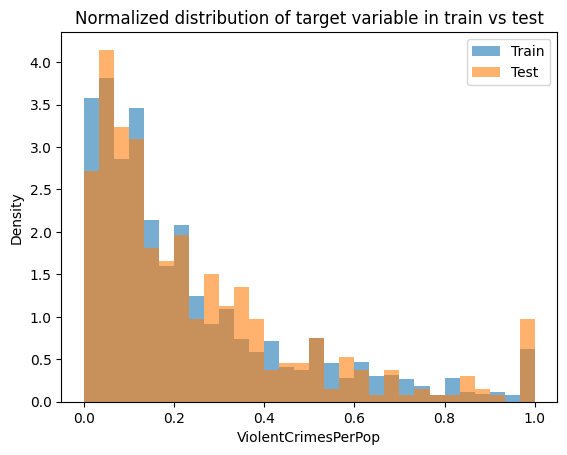

In [462]:
# Columns that must be excluded
exclude_cols = ["state", "county", "community", "communityname", "fold"]

# Target
target_col = "ViolentCrimesPerPop"

X = data.drop(columns=exclude_cols + [target_col]).copy()
y = data[target_col].copy()

# Train/test split (same as in Assignment 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, seed=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

print(
    f"Train target mean: {y_train.mean():.3f}, "
    f"Test target mean: {y_test.mean():.3f}"
)

plt.hist(y_train, bins=30, alpha=0.6, label="Train", density=True)
plt.hist(y_test, bins=30, alpha=0.6, label="Test", density=True)

plt.xlabel("ViolentCrimesPerPop")
plt.ylabel("Density")
plt.title("Normalized distribution of target variable in train vs test")
plt.legend()
plt.show()

---
#### Full version with missing-value indicators (same as Assignment 2)

We will:
- Create binary indicators `*_was_missing` for all columns with missing values
- Keep track of which columns are indicators

We will use this full version as the basis for Ridge and Lasso.

In [463]:
# Ordinal column
ordinal_cols = ["LemasGangUnitDeploy"]

# Columns with missing values
miss_cols = [col for col in X_train.columns if X_train[col].isnull().any()]

X_train_full = X_train.copy()
X_test_full = X_test.copy()

# Add missing indicators
for col in miss_cols:
    X_train_full[f"{col}_was_missing"] = X_train_full[col].isnull().astype(int)
    X_test_full[f"{col}_was_missing"] = X_test_full[col].isnull().astype(int)

# Missing indicator column names
missing_indicators = [
    column for column in X_train_full.columns if column.endswith("_was_missing")
]

print(f"Added missing indicators for {len(miss_cols)} columns.\n")
print("Old -> new shapes:")
print(f"-> Train: {X_train.shape} -> {X_train_full.shape}")
print(f"-> Test: {X_test.shape} -> {X_test_full.shape}")

Added missing indicators for 23 columns.

Old -> new shapes:
-> Train: (1596, 122) -> (1596, 145)
-> Test: (398, 122) -> (398, 145)


---
#### Imputation and standardization for the full dataset

We will now apply **impute_and_standardize()**:
- Fit imputation and scaling parameters
- Apply them to both train and test sets
- Continuous features are standardized, ordinal and indicator columns are left as they are

In [464]:
X_train_full_proc, X_test_full_proc, params_full = impute_and_standardize(
    X_train_full,
    X_test_full,
    ordinal_cols=ordinal_cols,
)

---
#### Fit Ridge and Lasso regression

##### Ridge regression (alpha = 1.0)

In [465]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_full_proc, y_train)

ridge_pred = ridge_model.predict(X_test_full_proc)

ridge_results = {
    "RMSE": rmse(y_test, ridge_pred),
    "MAE": mean_absolute_error(y_test, ridge_pred),
    "MSE": mean_squared_error(y_test, ridge_pred),
    "R2": r2_score(y_test, ridge_pred),
}

print("Ridge regression results (alpha = 1.0):")
for k, v in ridge_results.items():
    print(f"{k}: {v:.4f}")

Ridge regression results (alpha = 1.0):
RMSE: 0.1432
MAE: 0.1005
MSE: 0.0205
R2: 0.6354


##### Lasso regression (alpha = 1.0)

In [466]:
lasso_model = Lasso(alpha=1.0, max_iter=10000)
lasso_model.fit(X_train_full_proc, y_train)

lasso_pred = lasso_model.predict(X_test_full_proc)

lasso_results = {
    "RMSE": rmse(y_test, lasso_pred),
    "MAE": mean_absolute_error(y_test, lasso_pred),
    "MSE": mean_squared_error(y_test, lasso_pred),
    "R2": r2_score(y_test, lasso_pred),
}

print("\nLasso regression results (alpha = 1.0):")
for k, v in lasso_results.items():
    print(f"{k}: {v:.4f}")


Lasso regression results (alpha = 1.0):
RMSE: 0.2374
MAE: 0.1781
MSE: 0.0563
R2: -0.0013


---
#### Hyperparameter tuning for Ridge and Lasso - with CV

In [467]:
# Log space grid of alphas
alphas = np.logspace(-4, 4, 20)

##### RidgeCV: optimal alpha search

In [468]:
ridge_cv = RidgeCV(alphas=alphas)
ridge_cv.fit(X_train_full_proc, y_train)

ridge_best_alpha = ridge_cv.alpha_
print(f"Best Ridge alpha: {ridge_best_alpha:.6f}")

ridge_cv_pred = ridge_cv.predict(X_test_full_proc)

ridge_cv_results = {
    "RMSE": rmse(y_test, ridge_cv_pred),
    "MAE": mean_absolute_error(y_test, ridge_cv_pred),
    "MSE": mean_squared_error(y_test, ridge_cv_pred),
    "R2": r2_score(y_test, ridge_cv_pred),
}

print("\nRidgeCV performance on test set:")
for k, v in ridge_cv_results.items():
    print(f"{k}: {v:.4f}")

Best Ridge alpha: 78.475997

RidgeCV performance on test set:
RMSE: 0.1424
MAE: 0.0970
MSE: 0.0203
R2: 0.6398


##### LassoCV: optimal alpha search

In [469]:
lasso_cv = LassoCV(
    alphas=alphas,
    max_iter=20000,
    cv=5,
    n_jobs=-1,
    verbose=False,
    random_state=42,
)

lasso_cv.fit(X_train_full_proc, y_train)

lasso_best_alpha = lasso_cv.alpha_
print(f"Best Lasso alpha: {lasso_best_alpha:.6f}")

lasso_cv_pred = lasso_cv.predict(X_test_full_proc)

lasso_cv_results = {
    "RMSE": rmse(y_test, lasso_cv_pred),
    "MAE": mean_absolute_error(y_test, lasso_cv_pred),
    "MSE": mean_squared_error(y_test, lasso_cv_pred),
    "R2": r2_score(y_test, lasso_cv_pred),
}

print("\nLassoCV performance on test set:")
for k, v in lasso_cv_results.items():
    print(f"{k}: {v:.4f}")

Best Lasso alpha: 0.000695

LassoCV performance on test set:
RMSE: 0.1415
MAE: 0.0967
MSE: 0.0200
R2: 0.6441


---
#### Compare forward-selected features with features that Lasso selected

In [470]:
# Features selected by Lasso (non-zero coefficients)
lasso_coefs = lasso_cv.coef_
lasso_selected_features = [
    feature
    for feature, coef in zip(X_train_full_proc.columns, lasso_coefs)
    if abs(coef) > 1e-8
]

print(f"Lasso selected {len(lasso_selected_features)} features:")
for f in lasso_selected_features:
    print(f"- {f}")

# This is from Assignment 2
forward_selected = [
    "MedOwnCostPctIncNoMtg",
    "PctPolicHisp",
    "PctEmplManu",
    "agePct65up",
    "PctSameState85",
    "PctVacMore6Mos",
    "OtherPerCap_was_missing",
]

# Features selected by both Lasso and forward selection
overlap = list(set(lasso_selected_features) & set(forward_selected))

# Features only Lasso selected
lasso_only = list(set(lasso_selected_features) - set(forward_selected))

# Features only forward selection selected
forward_only = list(set(forward_selected) - set(lasso_selected_features))

print("\nComparison:\n")
print("Features selected by both Lasso and forward selection:")
for f in overlap:
    print(f"- {f}")

print("\nFeatures selected only by Lasso:")
for f in lasso_only:
    print(f"- {f}")

print("\nFeatures selected only by forward selection:")
for f in forward_only:
    print(f"- {f}")

Lasso selected 79 features:
- householdsize
- racepctblack
- racePctWhite
- racePctAsian
- racePctHisp
- agePct12t21
- agePct12t29
- pctUrban
- pctWWage
- pctWFarmSelf
- pctWInvInc
- pctWSocSec
- pctWRetire
- medFamInc
- whitePerCap
- blackPerCap
- indianPerCap
- AsianPerCap
- OtherPerCap
- HispPerCap
- PctPopUnderPov
- PctLess9thGrade
- PctEmploy
- PctEmplManu
- PctEmplProfServ
- PctOccupManu
- MalePctDivorce
- MalePctNevMarr
- FemalePctDiv
- PctFam2Par
- PctKids2Par
- PctYoungKids2Par
- PctWorkMom
- NumIlleg
- PctIlleg
- NumImmig
- PctRecImmig8
- PctNotSpeakEnglWell
- PctLargHouseFam
- PersPerOccupHous
- PersPerOwnOccHous
- PctPersOwnOccup
- PctPersDenseHous
- PctHousLess3BR
- MedNumBR
- HousVacant
- PctHousOccup
- PctVacantBoarded
- PctVacMore6Mos
- MedYrHousBuilt
- PctHousNoPhone
- PctWOFullPlumb
- OwnOccLowQuart
- RentLowQ
- MedRent
- MedRentPctHousInc
- MedOwnCostPctInc
- MedOwnCostPctIncNoMtg
- NumInShelters
- NumStreet
- PctForeignBorn
- PctSameCity85
- PolicReqPerOffic
- Polic

##### Comment on Lasso vs forward feature selection

Lasso kept 79 features, while forward selection kept only 7.
This happens because:
- Lasso looks at all features at once and the penalty was weak, so many coefficients stayed non-zero.
- Forward selection adds features one by one and usually stops early.

Both methods agreed on 4 features (PctEmplManu, PctVacMore6Mos, MedOwnCostPctIncNoMtg, PctPolicHisp), which suggests these are strong predictors.
Forward selection picked a few features that Lasso dropped, mainly because Lasso removes features that are highly correlated with others.
Overall, Lasso and Ridge performed better because they can use many predictors at the same time.

---
### Part 2: Wine quality dataset

#### Load dataset

In [471]:
# White wine dataset
wine = pd.read_csv("data/wine+quality/winequality-white.csv", sep=";")

print("White wine dataset shape:", wine.shape)
display(wine.head())

X_wine = wine.drop(columns=["quality"]).copy()
y_wine = wine["quality"].copy()

print("Feature shape:", X_wine.shape)
print("Target shape:", y_wine.shape)

White wine dataset shape: (4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Feature shape: (4898, 11)
Target shape: (4898,)


---
#### Train/Test split and basic setup

Wine train shape: (3919, 11)
Wine test shape:  (979, 11)
Processed wine shapes:
Train: (3919, 11)
Test:  (979, 11)


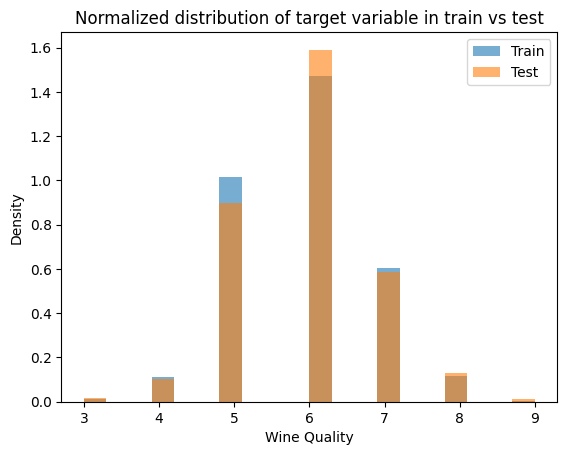

In [472]:
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(
    X_wine, y_wine, test_size=0.2, seed=42
)

print(f"Wine train shape: {X_wine_train.shape}")
print(f"Wine test shape:  {X_wine_test.shape}")

# Impute and standardize
X_wine_train_proc, X_wine_test_proc, wine_params = impute_and_standardize(
    X_wine_train,
    X_wine_test,
    ordinal_cols=None,
)

print("Processed wine shapes:")
print("Train:", X_wine_train_proc.shape)
print("Test: ", X_wine_test_proc.shape)

# Check: normalized distribution of target values
plt.hist(y_wine_train, bins=20, alpha=0.6, label="Train", density=True)
plt.hist(y_wine_test, bins=20, alpha=0.6, label="Test", density=True)

plt.xlabel("Wine Quality")
plt.ylabel("Density")
plt.title("Normalized distribution of target variable in train vs test")
plt.legend()
plt.show()

---
#### Batch GD and Stochastic GD

In [473]:
X_train_np = X_wine_train_proc.to_numpy()
y_train_np = y_wine_train.to_numpy()
X_test_np = X_wine_test_proc.to_numpy()
y_test_np = y_wine_test.to_numpy()

##### Batch gradient descent

In [474]:
w_bgd, history_bgd = ridge_bgd(
    X_train_np, y_train_np, lr=0.001, lam=0.1, max_iter=5000, tol=1e-6
)

# Add bias column to test data
X_test_aug = np.hstack([np.ones((X_test_np.shape[0], 1)), X_test_np])
y_pred_bgd = X_test_aug @ w_bgd

# Evaluate
bgd_rmse = rmse(y_test_np, y_pred_bgd)
bgd_mae = mean_absolute_error(y_test_np, y_pred_bgd)
bgd_mse = mean_squared_error(y_test_np, y_pred_bgd)
bgd_r2 = r2_score(y_test_np, y_pred_bgd)

print("Batch gradient descent results:")
print(f"RMSE: {bgd_rmse:.4f}")
print(f"MAE: {bgd_mae:.4f}")
print(f"MSE: {bgd_mse:.4f}")
print(f"R2: {bgd_r2:.4f}")

Batch gradient descent results:
RMSE: 0.7591
MAE: 0.5761
MSE: 0.5762
R2: 0.2704


##### Stochastic gradient descent

In [475]:
w_sgd, history_sgd = ridge_sgd(
    X_train_np,
    y_train_np,
    lr=0.001,
    lam=0.1,
    max_epochs=50,
    tol=1e-6,
    shuffle=True,
    seed=42,
)

y_pred_sgd = X_test_aug @ w_sgd

# Evaluate
sgd_rmse = rmse(y_test_np, y_pred_sgd)
sgd_mae = mean_absolute_error(y_test_np, y_pred_sgd)
sgd_mse = mean_squared_error(y_test_np, y_pred_sgd)
sgd_r2 = r2_score(y_test_np, y_pred_sgd)

print("\nStochastic gradient descent results:")
print(f"RMSE: {sgd_rmse:.4f}")
print(f"MAE: {sgd_mae:.4f}")
print(f"MSE: {sgd_mse:.4f}")
print(f"R2: {sgd_r2:.4f}")


Stochastic gradient descent results:
RMSE: 0.7596
MAE: 0.5730
MSE: 0.5771
R2: 0.2693


##### Convergence curves for BGD and SGD

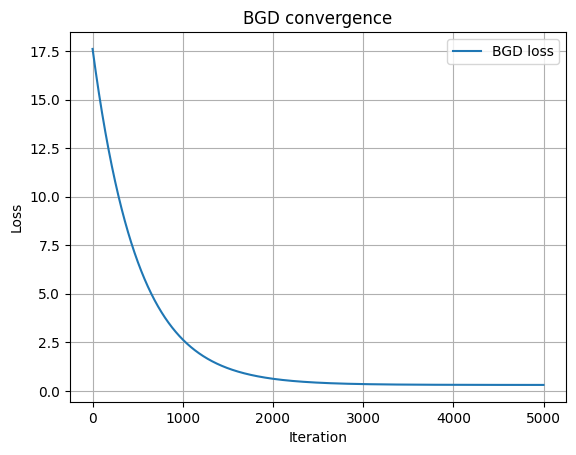

In [476]:
plt.plot(history_bgd, label="BGD loss")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("BGD convergence")

plt.legend()
plt.grid(True)
plt.show()

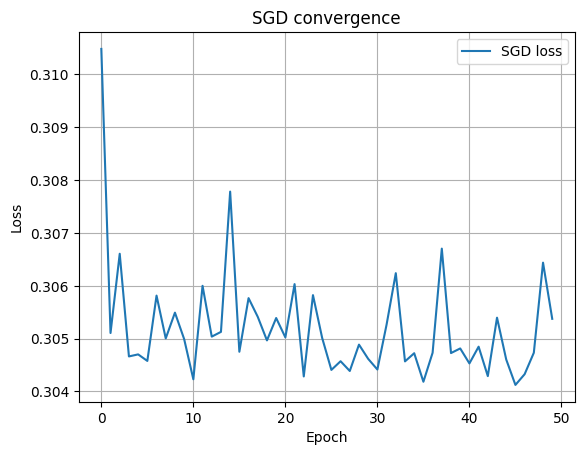

In [477]:
plt.plot(history_sgd, label="SGD loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SGD convergence")

plt.legend()
plt.grid(True)
plt.show()

---
#### Different learning rates for BGD and SGD

In [478]:
# We will use part of the training data as a validation set
X_wine_tr_inner, X_wine_val_inner, y_wine_tr_inner, y_wine_val_inner = train_test_split(
    X_wine_train_proc, y_wine_train, test_size=0.2, seed=42
)

X_tr_inner_np = X_wine_tr_inner.to_numpy()
X_val_inner_np = X_wine_val_inner.to_numpy()
y_tr_inner_np = y_wine_tr_inner.to_numpy()
y_val_inner_np = y_wine_val_inner.to_numpy()

X_test_np = X_wine_test_proc.to_numpy()
y_test_np = y_wine_test.to_numpy()

# Build validation and test matrices for bias term
X_val_aug = np.hstack([np.ones((X_val_inner_np.shape[0], 1)), X_val_inner_np])
X_test_aug = np.hstack([np.ones((X_test_np.shape[0], 1)), X_test_np])

In [479]:
learning_rates = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

results_bgd = []
results_sgd = []

for lr in learning_rates:
    print(f"\nLearning rate: {lr} ---------------------------------")

    # BGD
    w_bgd_lr, hist_bgd_lr = ridge_bgd(
        X_tr_inner_np, y_tr_inner_np, lr=lr, lam=0.1, max_iter=5000, tol=1e-6
    )

    y_val_pred_bgd = X_val_aug @ w_bgd_lr

    bgd_rmse_val = rmse(y_val_inner_np, y_val_pred_bgd)
    print(f"BGD validation RMSE: {bgd_rmse_val:.4f}")

    results_bgd.append((lr, bgd_rmse_val))

    # SGD
    w_sgd_lr, hist_sgd_lr = ridge_sgd(
        X_tr_inner_np, y_tr_inner_np, lr=lr, lam=0.1, max_epochs=50, tol=1e-6, seed=42
    )

    y_val_pred_sgd = X_val_aug @ w_sgd_lr

    sgd_rmse_val = rmse(y_val_inner_np, y_val_pred_sgd)
    print(f"SGD validation RMSE: {sgd_rmse_val:.4f}")

    results_sgd.append((lr, sgd_rmse_val))

print("\nLearning rate results on validation set (BGD):")
for lr, err in results_bgd:
    print(f"lr = {lr}: val RMSE = {err:.4f}")

print("\nLearning rate results on validation set (SGD):")
for lr, err in results_sgd:
    print(f"lr = {lr}: val RMSE = {err:.4f}")


Learning rate: 1e-06 ---------------------------------
BGD validation RMSE: 5.8582
SGD validation RMSE: 5.0372

Learning rate: 1e-05 ---------------------------------
BGD validation RMSE: 5.6012
SGD validation RMSE: 3.0981

Learning rate: 0.0001 ---------------------------------
BGD validation RMSE: 3.5952
SGD validation RMSE: 0.7405

Learning rate: 0.001 ---------------------------------
BGD validation RMSE: 0.7391
SGD validation RMSE: 0.7433

Learning rate: 0.01 ---------------------------------
BGD validation RMSE: 0.7402
SGD validation RMSE: 0.7523

Learning rate: 0.1 ---------------------------------
BGD validation RMSE: 0.7402
SGD validation RMSE: 1.4997

Learning rate results on validation set (BGD):
lr = 1e-06: val RMSE = 5.8582
lr = 1e-05: val RMSE = 5.6012
lr = 0.0001: val RMSE = 3.5952
lr = 0.001: val RMSE = 0.7391
lr = 0.01: val RMSE = 0.7402
lr = 0.1: val RMSE = 0.7402

Learning rate results on validation set (SGD):
lr = 1e-06: val RMSE = 5.0372
lr = 1e-05: val RMSE = 3.0

##### Comment on learning rates for batch GD and stochastic GD

**BGD**:
- Very small LRs learn too slowly.
- Best LR is 1e-3 (lowest validation RMSE).

**SGD**:
- Works best with smaller LRs.
- Best LR is 1e-4.
- Large LRs, especially 0.1, become unstable.

---
#### Convergence time and results of BGD and SGD

Comparison:
BGD time: 0.3166s, iterations: 5000, RMSE: 0.7591
SGD time: 2.0313s, epochs: 50, RMSE: 0.7551


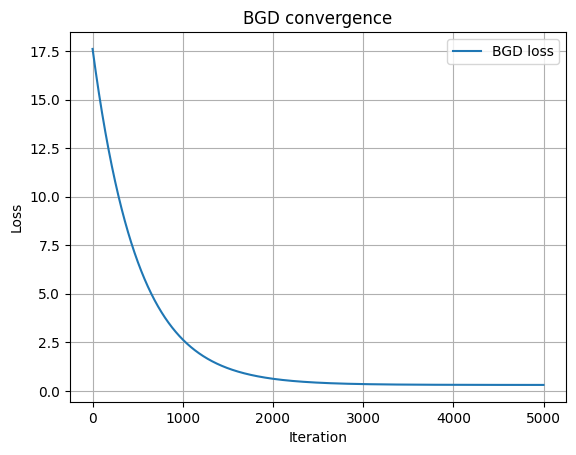

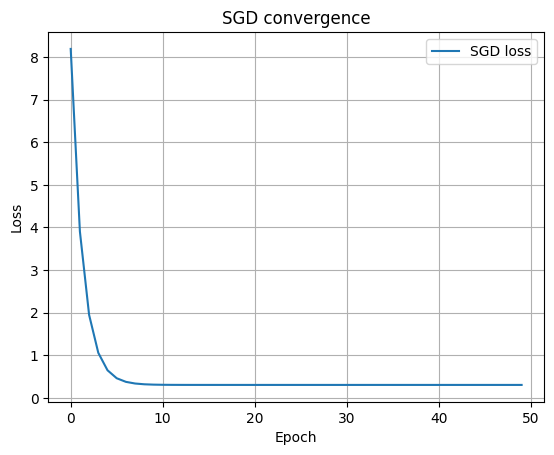

In [480]:
# BGD
start_bgd = time.time()
w_bgd_final, hist_bgd_final = ridge_bgd(
    X_train_np,
    y_train_np,
    lr=1e-3,
    lam=0.1,
    max_iter=5000,
    tol=1e-6,
)
end_bgd = time.time()

bgd_time = end_bgd - start_bgd
bgd_iters = len(hist_bgd_final)

# Evaluate
y_pred_bgd_final = X_test_aug @ w_bgd_final
bgd_rmse_final = rmse(y_test_np, y_pred_bgd_final)

# SGD
start_sgd = time.time()
w_sgd_final, hist_sgd_final = ridge_sgd(
    X_train_np, y_train_np, lr=1e-4, lam=0.1, max_epochs=50, tol=1e-6, seed=42
)
end_sgd = time.time()

sgd_time = end_sgd - start_sgd
sgd_epochs = len(hist_sgd_final)

# Evaluate
y_pred_sgd_final = X_test_aug @ w_sgd_final
sgd_rmse_final = rmse(y_test_np, y_pred_sgd_final)

print("Comparison:")
print(f"BGD time: {bgd_time:.4f}s, iterations: {bgd_iters}, RMSE: {bgd_rmse_final:.4f}")
print(f"SGD time: {sgd_time:.4f}s, epochs: {sgd_epochs}, RMSE: {sgd_rmse_final:.4f}")

plt.plot(hist_bgd_final, label="BGD loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("BGD convergence")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(hist_sgd_final, label="SGD loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SGD convergence")
plt.legend()
plt.grid(True)
plt.show()

##### Comments on BGD vs SGD

The BGD loss curve decreases smoothly and consistently. The loss drops quickly at the start and then flattens as it approaches its minimum. Overall, the convergence is steady and stable.

The SGD loss curve shows a fast drop in the first few epochs and then levels off. SGD reaches a similar final loss value as BGD.